In [ ]:
!pip install transformers
!pip install datasets 
!pip install rouge-score
!pip install itertools
!pip install datasets transformers rouge_score
!pip install pytube pysrt moviepy SpeechRecognition pydub
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import pipeline
from rouge_score import rouge_scorer
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import os
import json
import numpy as np
import pandas as pd
from itertools import islice

# Load ARXIV dataset
# arxiv_dataset = load_dataset('arxiv', 'cs.CL', split='test')
#Utility function to yield data from the stored file
def extract_data(datapath):
    with open(datapath, 'r') as datafile:
        for line in datafile:
            yield line


BASE_PATH = '/content/drive/MyDrive/archive'
FILE_NAME =  'arxiv-metadata-oai-snapshot.json'
FILE_PATH = os.path.join(BASE_PATH, FILE_NAME)

#Extracting data from input file as a data generator
data_gen = extract_data(FILE_PATH)

#Utility function to yield N records from the data generator
def fetch_n_records(data_gen, chunksize=500):
    return [json.loads(record) for record in islice(data_gen, chunksize)]

#Fetching 150000 records from the given data for the use of recommender systems
CHUNK_SIZE = 250000
data_records = fetch_n_records(data_gen, CHUNK_SIZE)

#Resampling method to fetch records for generating user_profile and recommendation algorithm
def split_records(data_records, profile_capacity=100, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(data_records)
    profile_records, recommend_records = data_records[:profile_capacity], data_records[profile_capacity:]
    return profile_records, recommend_records

#Splitting the fetched records into profile and recommendation records
profile_records, recommend_records = split_records(data_records, profile_capacity=500)

#Utility function to yield N records from the data generator
def fetch_n_records(data_gen, chunksize=500):
    return [json.loads(record) for record in islice(data_gen, chunksize)]

#Fetching 150000 records from the given data for the use of recommender systems
CHUNK_SIZE = 250000
data_records = fetch_n_records(data_gen, CHUNK_SIZE)

#Resampling method to fetch records for generating user_profile and recommendation algorithm
def split_records(data_records, profile_capacity=100, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(data_records)
    profile_records, recommend_records = data_records[:profile_capacity], data_records[profile_capacity:]
    return profile_records, recommend_records

#Splitting the fetched records into profile and recommendation records
profile_records, recommend_records = split_records(data_records, profile_capacity=500)

#Utility method to generate dataframe from list of dictionaries
def get_dataframe(list_of_dicts, columns=None):
    data = pd.DataFrame(list_of_dicts)
    if columns:
        data.columns = columns
    return data

#Generating dataframes for profile and recommend records
recommend_df = get_dataframe(recommend_records)

# Utility method to filter out certain features which are of use
def filter_features(data, features):
    return data[features]

#Filtering the profile and recommendation dataframes for useful features
useful_features = ['title', 'abstract']
recommend_df = filter_features(recommend_df, useful_features)

recommend_df.head()

,title,abstract
0,Radio polarization observations of large super...,We have observed 79 supernova remnants (SNRs...
1,Origin and Loss of nebula-captured hydrogen en...,We investigate the origin and loss of captur...
2,Stable black hole solutions with non-Abelian f...,"We construct finite mass, asymptotically fla..."
3,Calibration and performance of the photon-coun...,"We describe calibration data, and discuss pe..."
4,Black hole hair in Lovelock gravity,We present a method to analyse black hole ha...


In [ ]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import pytube, pysrt
import moviepy.editor as mp
import speech_recognition as sr
from transformers import pipeline, TFAutoModelWithLMHead, AutoTokenizer
from pydub import AudioSegment
from pydub.silence import split_on_silence
from datasets import load_dataset, load_metric
     

In [ ]:
model = TFAutoModelWithLMHead.from_pretrained("facebook/bart-large-cnn")
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")


rouge = load_metric('rouge')
rouge



  warnings.warn(

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-cnn.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
  rouge = load_metric('rouge')



Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [ ]:
# Summarize each paper in ARXIV dataset and evaluate
paper_sum = recommend_df['title']
paper_abs = recommend_df['abstract']
print(len(paper_sum))
len(paper_abs)

249500


249500

In [ ]:
def summarize(model, tokenizer, input_text, actual_summary):
    inputs = tokenizer.encode("summarize: " + input_text, return_tensors="tf", max_length=1024, truncation=True)
    outputs = model.generate(inputs, max_length=200, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True,  no_repeat_ngram_size=3)
    pred_summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in outputs]
    return pred_summary[0]

In [ ]:
pred_summary = []
for i in range(10):
  print(i)
  pred_summary.append(summarize(model, tokenizer, paper_abs[i], paper_sum[i]))
    

0
1
2
3
4
5
6
7
8
9


In [ ]:
pred_summary

NameError: ignored

In [ ]:
precision = []
recall = []
f1 = []
for i in range(len(pred_summary)):
    result = rouge.compute(predictions=[pred_summary[i]], references=[paper_sum[i]])
    precision.append(result["rouge1"].high.precision)
    recall.append(result["rouge1"].high.recall)
    f1.append(result["rouge1"].high.fmeasure)

Text(0.5, 1.0, 'ROUGE Score')

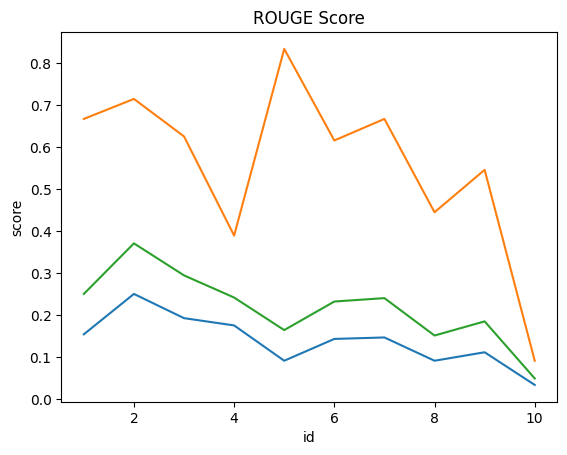

In [ ]:
n=10
indices = [i for i in range (1, n+1)]
plt.plot(indices, precision, label = "precision")
plt.plot(indices, recall, label = "recall")
plt.plot(indices, f1, label = "f1-score")
plt.xlabel('id')
plt.ylabel('score')
plt.title('ROUGE Score')
#plt.legend()

In [ ]:
pavg = sum(precision)/len(precision)
print('Precision:', pavg)

ravg = sum(recall)/len(recall)
print('Recall', ravg)

favg = sum(f1)/len(f1)
print('F1- Score', favg)

Precision: 0.13866150786882495
Recall 0.5591033966033966
F1- Score 0.21760250806212217


In [ ]:
precision = []
recall = []
f1 = []
for i in range(n):
    result = rouge.compute(predictions=[pred_summary[i]], references=[paper_sum[i]])
    precision.append(result["rouge2"].high.precision)
    recall.append(result["rouge2"].high.recall)
    f1.append(result["rouge2"].high.fmeasure)

In [ ]:
plt.plot(indices, precision, label = "precision")
plt.plot(indices, recall, label = "recall")
plt.plot(indices, f1, label = "f1-score")
plt.xlabel('id')
plt.ylabel('score')
plt.title('ROUGE Score')
#plt.legend()

In [ ]:
pavg = sum(precision)/len(precision)
print('Precision:', pavg)

ravg = sum(recall)/len(recall)
print('Recall', ravg)

favg = sum(f1)/len(f1)
print('F1- Score', favg)

In [ ]:
precision = []
recall = []
f1 = []
for i in range(n):
    result = rouge.compute(predictions=[pred_summary[i]], references=[paper_sum[i]])
    precision.append(result["rougeLsum"].high.precision)
    recall.append(result["rougeLsum"].high.recall)
    f1.append(result["rougeLsum"].high.fmeasure)